In [1]:
import numpy as np
import pandas as pd

# Data exploration

The first step to building a reliable machine learning model is to understand your data. ML lives and dies by the quality of the dataset.

Our dataset consists of two sets of files: train and test. The train set is the dataset that will be used for, well, training the model. To ensure that our model actually provides reliable predictions for proteins that aren't present in our training set, we also have a separate test set that we'll use to measure the performance of our model. 
X and y in filenames typically mean inputs and labels. That is, what we'll be inputting into the model (in our case, protein sequence) and what value we want to predict (temperature).

In [2]:
data_root = "../data"  # Remember to download the Kaggle dataset to here (from the README)


In [3]:
train_sequences = np.load(f"{data_root}/X_train.npy")
train_temperatures = np.load(f"{data_root}/y_train.npy")

test_sequences = np.load(f"{data_root}/X_test.npy")
test_temperatures = np.load(f"{data_root}/y_test.npy")

Let's look at our inputs first.

In [4]:
train_sequences.shape

(6149359, 650)

Our training sequence set has `6,149,359` records, each representing one protein. The longest protein in our dataset is 650 amino acids. Let's take a look at an example sequence.

In [5]:
train_sequences[0]

array([11, 15,  8,  6,  8, 10,  6,  1,  6, 14, 10,  6, 15, 11, 10,  1, 10,
        1,  6, 20, 13, 10,  3,  5,  3,  5, 18,  5, 10,  3, 13,  1, 17,  4,
        1,  2,  1,  1, 13, 10,  6, 17,  7,  5, 15,  1,  1, 20,  3,  3,  4,
       12,  1, 10, 16,  1,  5,  2,  6, 16,  8,  3, 18,  1, 17, 20,  4,  5,
        4, 12, 18, 13,  1,  9, 17,  1,  4,  5, 18, 16,  1, 15, 18, 13, 10,
       10, 13,  1, 13,  8,  1, 10, 16, 18,  6, 14,  3, 15, 10, 16,  4,  9,
       17, 10,  5,  3, 14, 10,  6,  8, 13, 18, 13, 15, 20, 10, 13, 18, 16,
       17, 15,  1,  3, 10,  3, 15,  1, 18,  7,  1,  8,  6, 10, 13,  1, 18,
       10,  9, 17, 15, 15, 10,  6, 20,  3,  6,  9,  6, 14,  1, 18, 10, 15,
       17, 13, 14,  3, 10,  3,  1,  1, 19,  1, 15, 10,  6, 17, 14, 13, 10,
        8, 10,  4,  1,  5, 18,  1,  5,  4, 15,  4, 10, 16,  2, 10,  1, 18,
       15,  3,  9, 12,  6,  1, 10,  1,  5, 20, 13, 18, 18,  4, 12, 18,  7,
       15,  3,  6,  8, 10, 15, 17,  1, 17, 13, 15,  1, 12,  3, 13, 10, 14,
       17, 14,  1,  4,  4

This dataset encodes protein sequences as integers. Each number represents one amino acid. Because proteins vary in length, most sequences will be padded with `0s` at the end.

Next, let's take a look at our labels: the temperatures our model will try to predict.

In [6]:
train_ds_temperatures = np.load(f"{data_root}/y_train.npy")
print(train_ds_temperatures.shape)
print(train_ds_temperatures[0])

(6149359,)
49.0


Pretty straightforward. The number of records is exactly the same as number of proteins, and the first protein is labeled as 49C.

## Data exploration

We need to understand how the dataset was created and what the labels mean.

In our case, this dataset was derived from the optimal growth temperature of each organism. This may not represent the actual thermostability of the protein. Proteins may be stable at higher temperatures than the organism itself evolved to live in, or there may be other mechanisms in the organism's cell that would stabilize the protein.
Besides that, we could make a few plots to understand our dataset better.

In [7]:
df_temperatures = pd.DataFrame(train_ds_temperatures, columns=["temperature"])
df_temperatures

,temperature
0,49.0
1,30.0
2,30.0
3,37.0
4,33.0
...,...
6149354,30.0
6149355,28.0
6149356,33.5
6149357,28.0


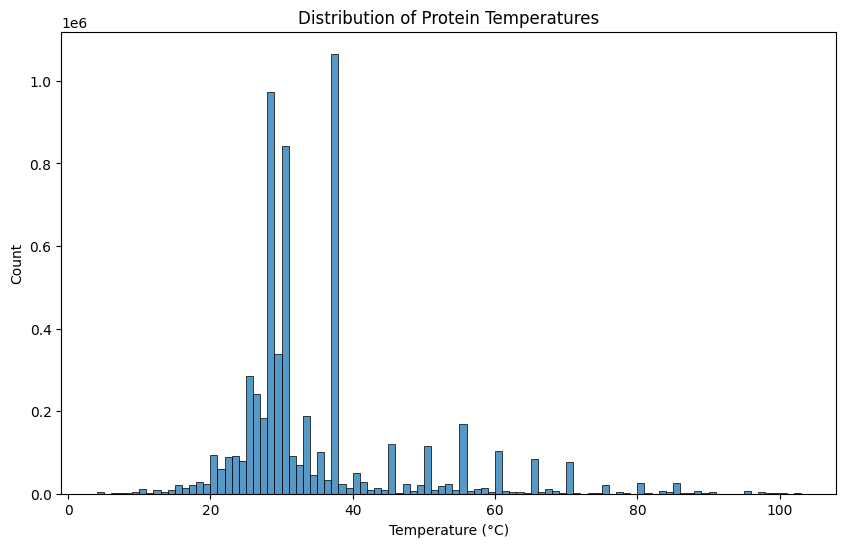

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(data=df_temperatures, x="temperature", binwidth=1)
plt.title("Distribution of Protein Temperatures")
plt.xlabel("Temperature (°C)")
plt.ylabel("Count")
plt.show()

This histogram tells us that our dataset is quite imbalanced. This is somewhat expected, as most of life exists in a range around 36C. That also tells us that our model may not be great at predicting proteins far outside of that range. We won't address the data imbalance in this tutorial, but it's good to be aware of it. 
Another observation is that most of our data has round numbers (around 5C increments). This isn't surprising and may not be too big of a deal, but if your goal is to predict temperature precisely, it may require some more thought.

We have quite a large set of 7 million proteins to work with. Let's use this to create a smaller dataset, around 10k sequences, that will also be more balanced and, therefore, help our model learn patterns across the whole range. We will lose some fidelity in our data, but  tradeoffs like this may be necessary depending on the specific requirements of the task.

Our free API tier allows generating embeddings for 2000 sequences, so let's create 10 temperature bins with (almost) 200 sequences each. This is a very small fraction of data, but should be enough to demonstrate that it's possible to train a functional model as a proof of concept even on such a tiny dataset.

In [9]:
target_per_bin = 190  # We'll use 1900 out of the 2000 free sequences, leaving us 100 sequences to play with

Original dataset size: 6,149,359
Balanced dataset size: 1900
Balanced sequences shape: (1900, 650)


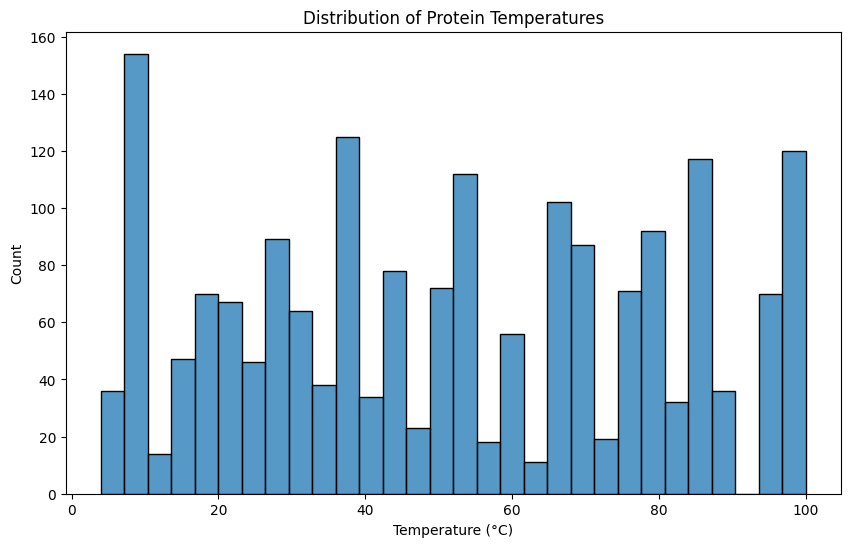

In [10]:
# Create bins for temperatures to help with balancing
bins = list(range(0, 101, 10))  # Create bins of 10 degrees from 0-100 
df_temperatures['temp_bin'] = pd.cut(df_temperatures['temperature'], bins=bins)

# Get counts per bin to determine sampling strategy
bin_counts = df_temperatures['temp_bin'].value_counts()


# Sample from each bin
balanced_indices = []
for bin_name in bin_counts.index:
    bin_df = df_temperatures[df_temperatures['temp_bin'] == bin_name]
    
    # If the bin has less than the target, take all samples
    # Otherwise sample target_per_bin entries
    n_samples = min(len(bin_df), target_per_bin)
    sampled_indices = bin_df.sample(n=n_samples).index
    balanced_indices.extend(sampled_indices)

# Convert indices list to numpy array for indexing
balanced_indices = np.array(balanced_indices)

# Get corresponding sequences
balanced_sequences = train_sequences[balanced_indices]

# Create a new balanced dataframe using the collected indices
df_temperatures_balanced = df_temperatures.loc[balanced_indices].copy()

# Drop the binning column and shuffle
df_temperatures_balanced = df_temperatures_balanced.drop('temp_bin', axis=1)

# Create a permutation for shuffling both arrays consistently
np.random.seed(42)
permutation = np.random.permutation(len(df_temperatures_balanced))
df_temperatures_balanced = df_temperatures_balanced.iloc[permutation].reset_index(drop=True)
balanced_sequences = balanced_sequences[permutation]

print(f"Original dataset size: {len(df_temperatures):,}")
print(f"Balanced dataset size: {len(df_temperatures_balanced)}")
print(f"Balanced sequences shape: {balanced_sequences.shape}")

plt.figure(figsize=(10, 6))
sns.histplot(data=df_temperatures_balanced, x="temperature", bins=30)
plt.title("Distribution of Protein Temperatures")
plt.xlabel("Temperature (°C)")
plt.ylabel("Count")
plt.show()

In [11]:
df_temperatures_balanced.head()

,temperature
0,80.0
1,26.0
2,60.0
3,60.0
4,75.0


Next, let's process our sequences, and convert them to sequences of single-letter amino acids (that's what our model expects).

In [12]:
def convert_sequence(protein):
    # Map numbers to amino acid letters
    number_to_aa = {
        1: 'A', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 
        9: 'K', 10: 'L', 11: 'M', 12: 'N', 13: 'P', 14: 'Q', 15: 'R',
        16: 'S', 17: 'T', 18: 'V', 19: 'W', 20: 'Y', 0: ''
    }
    return ''.join(number_to_aa[num] for num in protein)

def convert_to_sequences(protein_array):
    from multiprocessing import Pool
    import tqdm.auto as tqdm
    
    sequences = []
    for protein in protein_array:
        sequences.append(convert_sequence(protein))
    # Create dataframe
    return pd.DataFrame(sequences, columns=['sequence'])

# Convert the training sequences
df_sequences = convert_to_sequences(balanced_sequences)
print(f"Number of sequences: {len(df_sequences)}")
print("\nFirst sequence:")
print(df_sequences.iloc[0]['sequence'])


Number of sequences: 1900

First sequence:
MRKTALLLIFIIFSAGCLGGQKYTSTTVTETVKETVTETTTKTVRETTTETETKTMTETFTPIEKLKQLNSTIKELNQTVVRLNQSLTSCLSILSSQNETIIEQKEKINQLESAYLSCLLQKSTQQNSEFRVLFGREYYYEVLKTIEEANESIYIAMFLMKYDAGDSFDWANDLSRALVRAKKRGLNIYVVLENSVEINQAAYSYLRTNGIKVRFDSPDRTLHAKIVVIDGKVAFIGSHNWSESGLYWNNEVSVEIKSKEVAQEVISYIMSIQ


In [13]:
df_sequences["temperature"] = df_temperatures_balanced["temperature"]

df_sequences.head()

,sequence,temperature
0,MRKTALLLIFIIFSAGCLGGQKYTSTTVTETVKETVTETTTKTVRE...,80.0
1,MAADNSSTAAPAPSLRRDLKARHLSMIAIGGSIGTGLFVASGATIS...,26.0
2,MDWTIRLNRALDYIEDYLADEVDLDYAAKLAFCNRNDLSKMFFIVT...,60.0
3,MTRFGGVGSVNALVENQKAYLLSCQLPSGAFRLAPRRDQINPYFTN...,60.0
4,MQVQASSQGFLDVISAIYHIMEAEKVVESYDPKVCELLEQAKEYLI...,75.0


Let's dig a bit more into our result dataset.

Text(0.5, 1.0, 'Distribution of Protein Sequence Lengths')

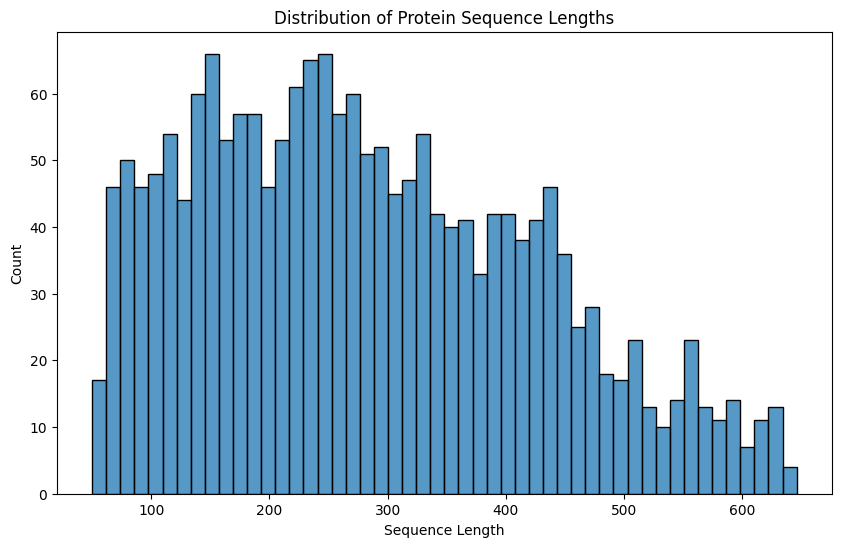

In [14]:
# Calculate sequence lengths
sequence_lengths = df_sequences['sequence'].str.len()

# Create histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.title('Distribution of Protein Sequence Lengths')


Our model API (https://models.ginkgobioworks.ai/) is priced per token. Tokens represent units of input that go into a model (e.g. words for text models). In the case of our protein models, tokens represent single amino acids.

In [15]:
# Calculate the total number of amino acids/tokens across all sequences
total_amino_acids = df_sequences['sequence'].str.len().sum()
print(f"Total number of tokens in dataset: {total_amino_acids:,}")


Total number of tokens in dataset: 538,146


Finally, we should split our data into a training set and a held-out test set, to see how well the model *generalizes* to unseen data. 

In [16]:
from sklearn.model_selection import train_test_split

# Create train/test split
train_df, test_df = train_test_split(df_sequences, test_size=0.2, random_state=42)

# Save to CSV files
train_df.to_csv("../data/train_df.csv", index=False)
test_df.to_csv("../data/test_df.csv", index=False)

print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")


Training set size: 1520
Test set size: 380
